In [30]:
dfp1 = df.iloc[-len(pred_test):, :]

pred_points = []
for i in range(len(pred_test)):
    if pred_test[i]==2:
        pred_points.append(dfp1['Low'][i]*0.98)
    elif pred_test[i]==1:
        pred_points.append(dfp1['High'][i]*1.02)
    else:
        pred_points.append(np.nan)
k = 365
dfp1 = dfp1.iloc[-k:, :]
fig = go.Figure(data=[go.Candlestick(x=dfp1.index, 
                open=dfp1["Open"],
                high=dfp1['High'],
                low=dfp1['Low'],
                close=dfp1['Close']),
                ])
fig.add_trace(go.Scatter(x=dfp1.index, y=dfp1["MA40"], mode='lines', name='ATR'))

fig.add_scatter(x=dfp1.index, y=pred_points[-k:], mode='markers',
                marker=dict(size=3, color="MediumPurple"), name='entry')
fig.show()

SBUX
****Train Results****
Accuracy: 99.3742%
****Test Results****
Accuracy: 69.5959%


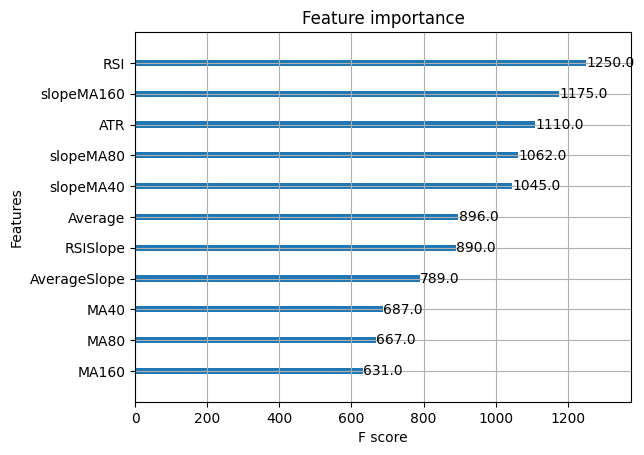

AMD
****Train Results****
Accuracy: 97.0625%
****Test Results****
Accuracy: 31.9872%


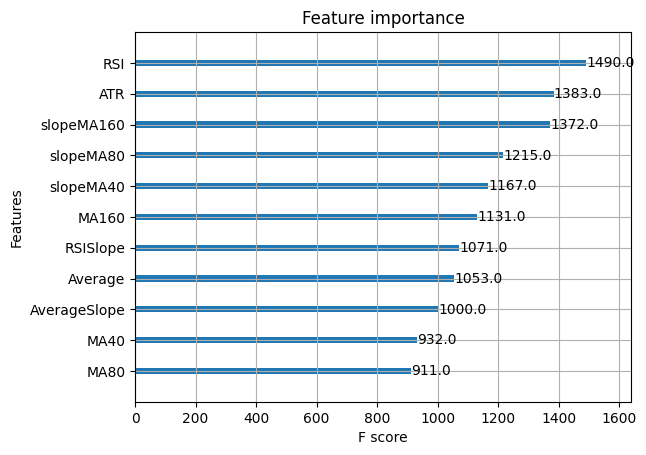

MCD
****Train Results****
Accuracy: 98.5166%
****Test Results****
Accuracy: 93.9288%


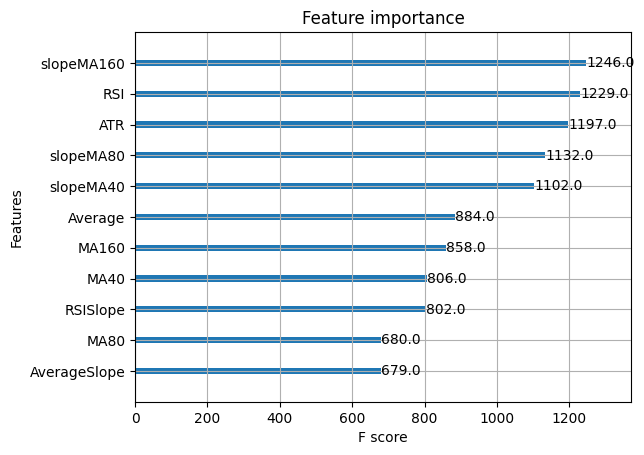

EXAS
****Train Results****
Accuracy: 98.8429%
****Test Results****
Accuracy: 31.4947%


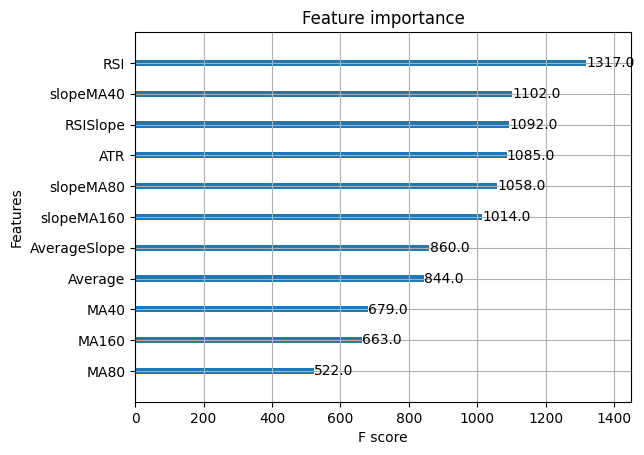

NVAX
****Train Results****
Accuracy: 98.1033%
****Test Results****
Accuracy: 33.9350%


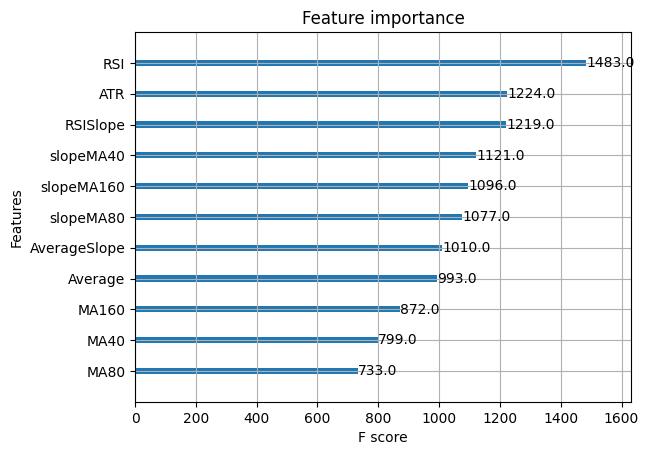

In [19]:
# looping
import pandas as pd
import yfinance as yf
from scipy.stats import linregress
import pandas_ta as ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import numpy as np
from matplotlib import pyplot
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
stocks = ["SBUX", "AMD", "MCD", "EXAS", "NVAX"]
for stock in stocks:
    df = yf.download(stock, interval="1d", progress = False)
    index_of_zero_volume = df[df['Volume'] == 0].index
    df.drop(index_of_zero_volume, inplace=True)

    df['ATR'] = df.ta.atr(length=20)
    df['RSI'] = df.ta.rsi()
    df['Average'] = df.ta.midprice(length=1) #midprice
    df['MA40'] = df.ta.sma(length=40)
    df['MA80'] = df.ta.sma(length=80)
    df['MA160'] = df.ta.sma(length=160)


    def get_slope(array):
        y = np.array(array)
        x = np.arange(len(y))
        slope, intercept, r_value, p_value, std_err = linregress(x,y)
        return slope

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    backrollingN = 6
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
    df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    def mytarget(barsupfront, df1):
        SLTPRatio = 2
        length = len(df1)
        high = list(df1['High'])
        low = list(df1['Low'])
        close = list(df1['Close'])
        open = list(df1['Open'])
        trendcat = [None] * length
        
        for line in range (0,length-barsupfront-2):
            pipdiff = close[line+1]*0.1
            valueOpenLow = 0
            valueOpenHigh = 0
            for i in range(1,barsupfront+2):
                value1 = open[line+1]-low[line+i]
                value2 = open[line+1]-high[line+i]
                valueOpenLow = max(value1, valueOpenLow)
                valueOpenHigh = min(value2, valueOpenHigh)

                if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                    trendcat[line] = 1 #-1 downtrend
                    break
                elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                    trendcat[line] = 2 # uptrend
                    break
                else:
                    trendcat[line] = 0 # no clear trend
                
        return trendcat
    df['mytarget'] = mytarget(16, df)

    df_model= df[['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
    df_model=df_model.dropna()

    attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    X = df_model[attributes]
    y = df_model["mytarget"]

    # X = df_model[["RSI", "ATR"]]

    #sequential sampling
    train_index = int(0.8 * len(X))
    X_train, X_test = X[:train_index], X[train_index:]
    y_train, y_test = y[:train_index], y[train_index:]


    model = XGBClassifier()
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    acc_train = accuracy_score(y_train, pred_train)
    acc_test = accuracy_score(y_test, pred_test)
    print(stock)
    print('****Train Results****')
    print("Accuracy: {:.4%}".format(acc_train))
    print('****Test Results****')
    print("Accuracy: {:.4%}".format(acc_test))
    #plot feature importance
    plot_importance(model)
    pyplot.show()

In [16]:
# load and save model
import joblib

# Load the saved model
# joblib.dump(model, 'SBUX.pkl')
loaded_model = joblib.load('SBUX.pkl')
# Assuming 'today_data' contains today's RSI and ATR values
today_data = pd.DataFrame({'RSI': [48.897382], 'ATR': [1.459789]})
today_prediction = loaded_model.predict(today_data)

# Interpret the prediction
if today_prediction == 2:
    signal = "Uptrend"
elif today_prediction == 1:
    signal = "Downtrend"
else:
    signal = "No Clear Trend"

print("Today's Signal:", signal)


Today's Signal: No Clear Trend


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

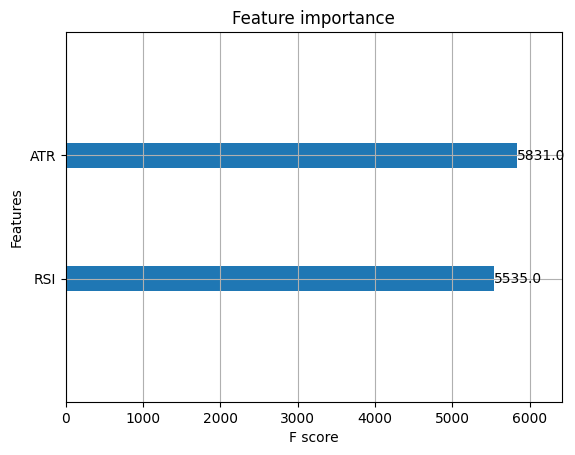

In [31]:
plot_importance(model)

In [7]:
today_data = pd.DataFrame({'RSI': [48.897382], 'ATR': [1.459789]})

# 3. Make Predictions
today_prediction = model.predict(today_data)

# 4. Interpret the Prediction
if today_prediction == 2:
    signal = "Uptrend"
elif today_prediction == 1:
    signal = "Downtrend"
else:
    signal = "No Clear Trend"

print("Today's Signal:", signal)

Today's Signal: No Clear Trend


In [ ]:
# plotting
dfp1 = df.iloc[-len(pred_test):, :]

pred_points = []
for i in range(len(pred_test)):
    if pred_test[i]==2:
        pred_points.append(dfp1['Low'][i]*0.98)
    elif pred_test[i]==1:
        pred_points.append(dfp1['High'][i]*1.02)
    else:
        pred_points.append(np.nan)
k = 365
dfp1 = dfp1.iloc[-k:, :]
fig = go.Figure(data=[go.Candlestick(x=dfp1.index, 
                open=dfp1["Open"],
                high=dfp1['High'],
                low=dfp1['Low'],
                close=dfp1['Close']),
                ])
fig.add_trace(go.Scatter(x=dfp1.index, y=dfp1["MA40"], mode='lines', name='ATR'))

fig.add_scatter(x=dfp1.index, y=pred_points[-k:], mode='markers',
                marker=dict(size=3, color="MediumPurple"), name='entry')
fig.show()

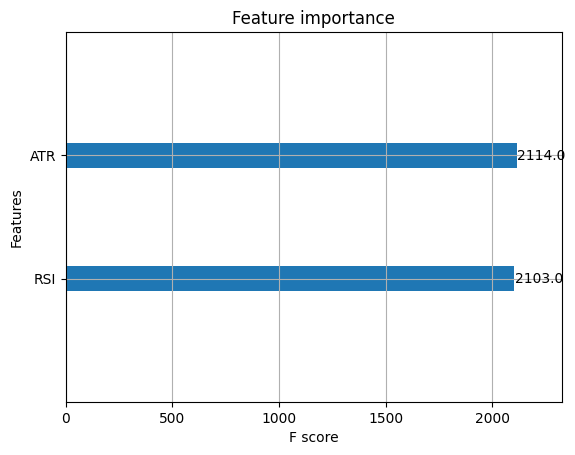

In [76]:
# feature importance matrix
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()